In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
df=pd.read_csv('lean_df.csv',index_col='id')
treat_df=df.copy()

/home/auscheng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (44,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/auscheng/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
treat_df.sample(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
106396522,40000.0,40000.0,40000.0,36 months,7.49,1244.07,A,A4,Sales,5 years,MORTGAGE,95000.0,Verified,May-2017,Current,debt_consolidation,604xx,IL,21.88,0.0,Jun-1993,730.0,734.0,0.0,67.0,NaN,16.0,0.0,19813.0,36.9,29.0,w,16627.90,16627.90,27352.900000,27352.90,23372.10,3980.80,0.00,0.0,0.0,Mar-2019,1244.07,Apr-2019,Mar-2019,794.0,790.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,2950.0,223311.0,1.0,4.0,1.0,1.0,6.0,39651.0,55.0,0.0,2.0,4729.0,47.0,53700.0,0.0,1.0,1.0,3.0,14887.0,21689.0,34.7,0.0,0.0,157.0,286.0,13.0,6.0,4.0,13.0,NaN,6.0,NaN,0.0,4.0,8.0,6.0,7.0,8.0,11.0,17.0,8.0,16.0,0.0,0.0,0.0,1.0,96.6,16.7,0.0,0.0,302109.0,59464.0,33200.0,72630.0,N,Cash,N
132490913,36000.0,36000.0,36000.0,36 months,9.92,1160.27,B,B2,OFAC Sanction Officer,2 years,MORTGAGE,98000.0,Not Verified,May-2018,Current,debt_consolidation,072xx,NJ,13.21,0.0,Jan-1999,685.0,689.0,0.0,NaN,NaN,16.0,0.0,37750.0,37.3,32.0,w,26730.30,26730.30,11863.020000,11863.02,9269.70,2593.32,0.00,0.0,0.0,Mar-2019,1160.27,Apr-2019,Mar-2019,794.0,790.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,37750.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,1.0,6.0,6063.0,37.0,101200.0,0.0,0.0,0.0,6.0,2517.0,60514.0,37.9,0.0,0.0,NaN,231.0,2.0,2.0,0.0,2.0,NaN,NaN,NaN,0.0,14.0,15.0,14.0,23.0,0.0,16.0,32.0,15.0,16.0,0.0,0.0,0.0,1.0,100.0,7.1,0.0,0.0,101200.0,37750.0,97400.0,0.0,N,Cash,N
129427365,10000.0,10000.0,10000.0,36 months,7.34,310.33,A,A4,Sr Loan Processor,2 years,MORTGAGE,80000.0,Not Verified,Mar-2018,Current,credit_card,852xx,AZ,9.60,0.0,Nov-2003,710.0,714.0,0.0,NaN,105.0,5.0,1.0,3075.0,23.7,16.0,f,6907.37,6907.37,3744.350000,3744.35,3092.63,651.72,0.00,0.0,0.0,Mar-2019,310.33,Apr-2019,Mar-2019,684.0,680.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,267318.0,2.0,2.0,0.0,1.0,24.0,7587.0,36.0,0.0,0.0,3075.0,31.0,13000.0,0.0,2.0,1.0,3.0,53464.0,9425.0,24.6,0.0,0.0,78.0,100.0,31.0,6.0,3.0,45.0,NaN,8.0,NaN,0.0,1.0,1.0,1.0,5.0,5.0,2.0,8.0,1.0,5.0,0.0,0.0,0.0,2.0,100.0,0.0,1.0,0.0,293060.0,10662.0,12500.0,21313.0,N,Cash,N
104492717,4800.0,4800.0,4800.0,36 months,11.44,158.15,B,B4,Finisher,10+ years,MORTGAGE,41000.0,Not Verified,Apr-2017,In Grace Period,debt_consolidation,170xx,PA,25.79,0.0,Aug-1989,675.0,679.0,0.0,NaN,82.0,9.0,1.0,5941.0,56.6,13.0,w,2063.45,2063.45,3489.980000,3489.98,2

#### Consolidate FICO Scores

In [4]:
treat_df['fico']=(treat_df.fico_range_low+treat_df.fico_range_high)/2
treat_df=treat_df.drop(['fico_range_low','fico_range_high','last_fico_range_high','last_fico_range_low'],axis=1)

#### Remove categories with big imbalance in representation (proportion of subcategories <5% in binary categories)

In [5]:
2259836*0.05

112991.8

In [6]:
treat_df['debt_settlement_flag'].value_counts()

N    2226422
Y      34246
Name: debt_settlement_flag, dtype: int64

In [7]:
treat_df['disbursement_method'].value_counts()

Cash         2182546
DirectPay      78122
Name: disbursement_method, dtype: int64

In [8]:
treat_df['hardship_flag'].value_counts()  

N    2259836
Y        832
Name: hardship_flag, dtype: int64

In [9]:
treat_df['initial_list_status'].value_counts()

w    1535467
f     725201
Name: initial_list_status, dtype: int64

In [10]:
treat_df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [11]:
treat_df['verification_status'].value_counts()

Source Verified    886231
Not Verified       744806
Verified           629631
Name: verification_status, dtype: int64

In [12]:
treat_df['home_ownership'].value_counts()

MORTGAGE    1111450
RENT         894929
OWN          253057
ANY             996
OTHER           182
NONE             54
Name: home_ownership, dtype: int64

#### Removing the ones with large misrepresentation:

In [13]:
treat_df=treat_df.drop(['debt_settlement_flag','disbursement_method','hardship_flag'],axis=1)

#### Quick Initial Definition of Variable Type (Continuous, Nominal, Ordinal)

In [14]:
df_number = treat_df.select_dtypes(include = 'number')
df_object = treat_df.select_dtypes(include = 'object')
df_category = treat_df.select_dtypes(include = 'category')
df_boolean = treat_df.select_dtypes(include = 'bool')
df_datetime = treat_df.select_dtypes(include = 'datetime')
df_timedelta = treat_df.select_dtypes(include = 'timedelta')
#######################################################
nominal_var=list(df_object.columns)
ordinal_var=list(df_number.columns)
continuous_var=list(df_number.columns)
time_var=list(df_datetime.columns)

In [15]:
df_number.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,122.67,0.0,30.0,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,677.0
68355089,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,926.35,0.0,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,717.0
68341763,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,15813.30,0.0,NaN,71000.0,13.85,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,NaN,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,697.0
66310712,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.6,17.0,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,829.90,0.0,NaN,NaN,NaN,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,67300.0,0.0,1.0,0.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,NaN,NaN,NaN,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,787.0
68476807,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,10128.96,0.0,NaN,NaN,NaN,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,697.0


#### Visual Check of MultiCollinearity: Plotting Pearson

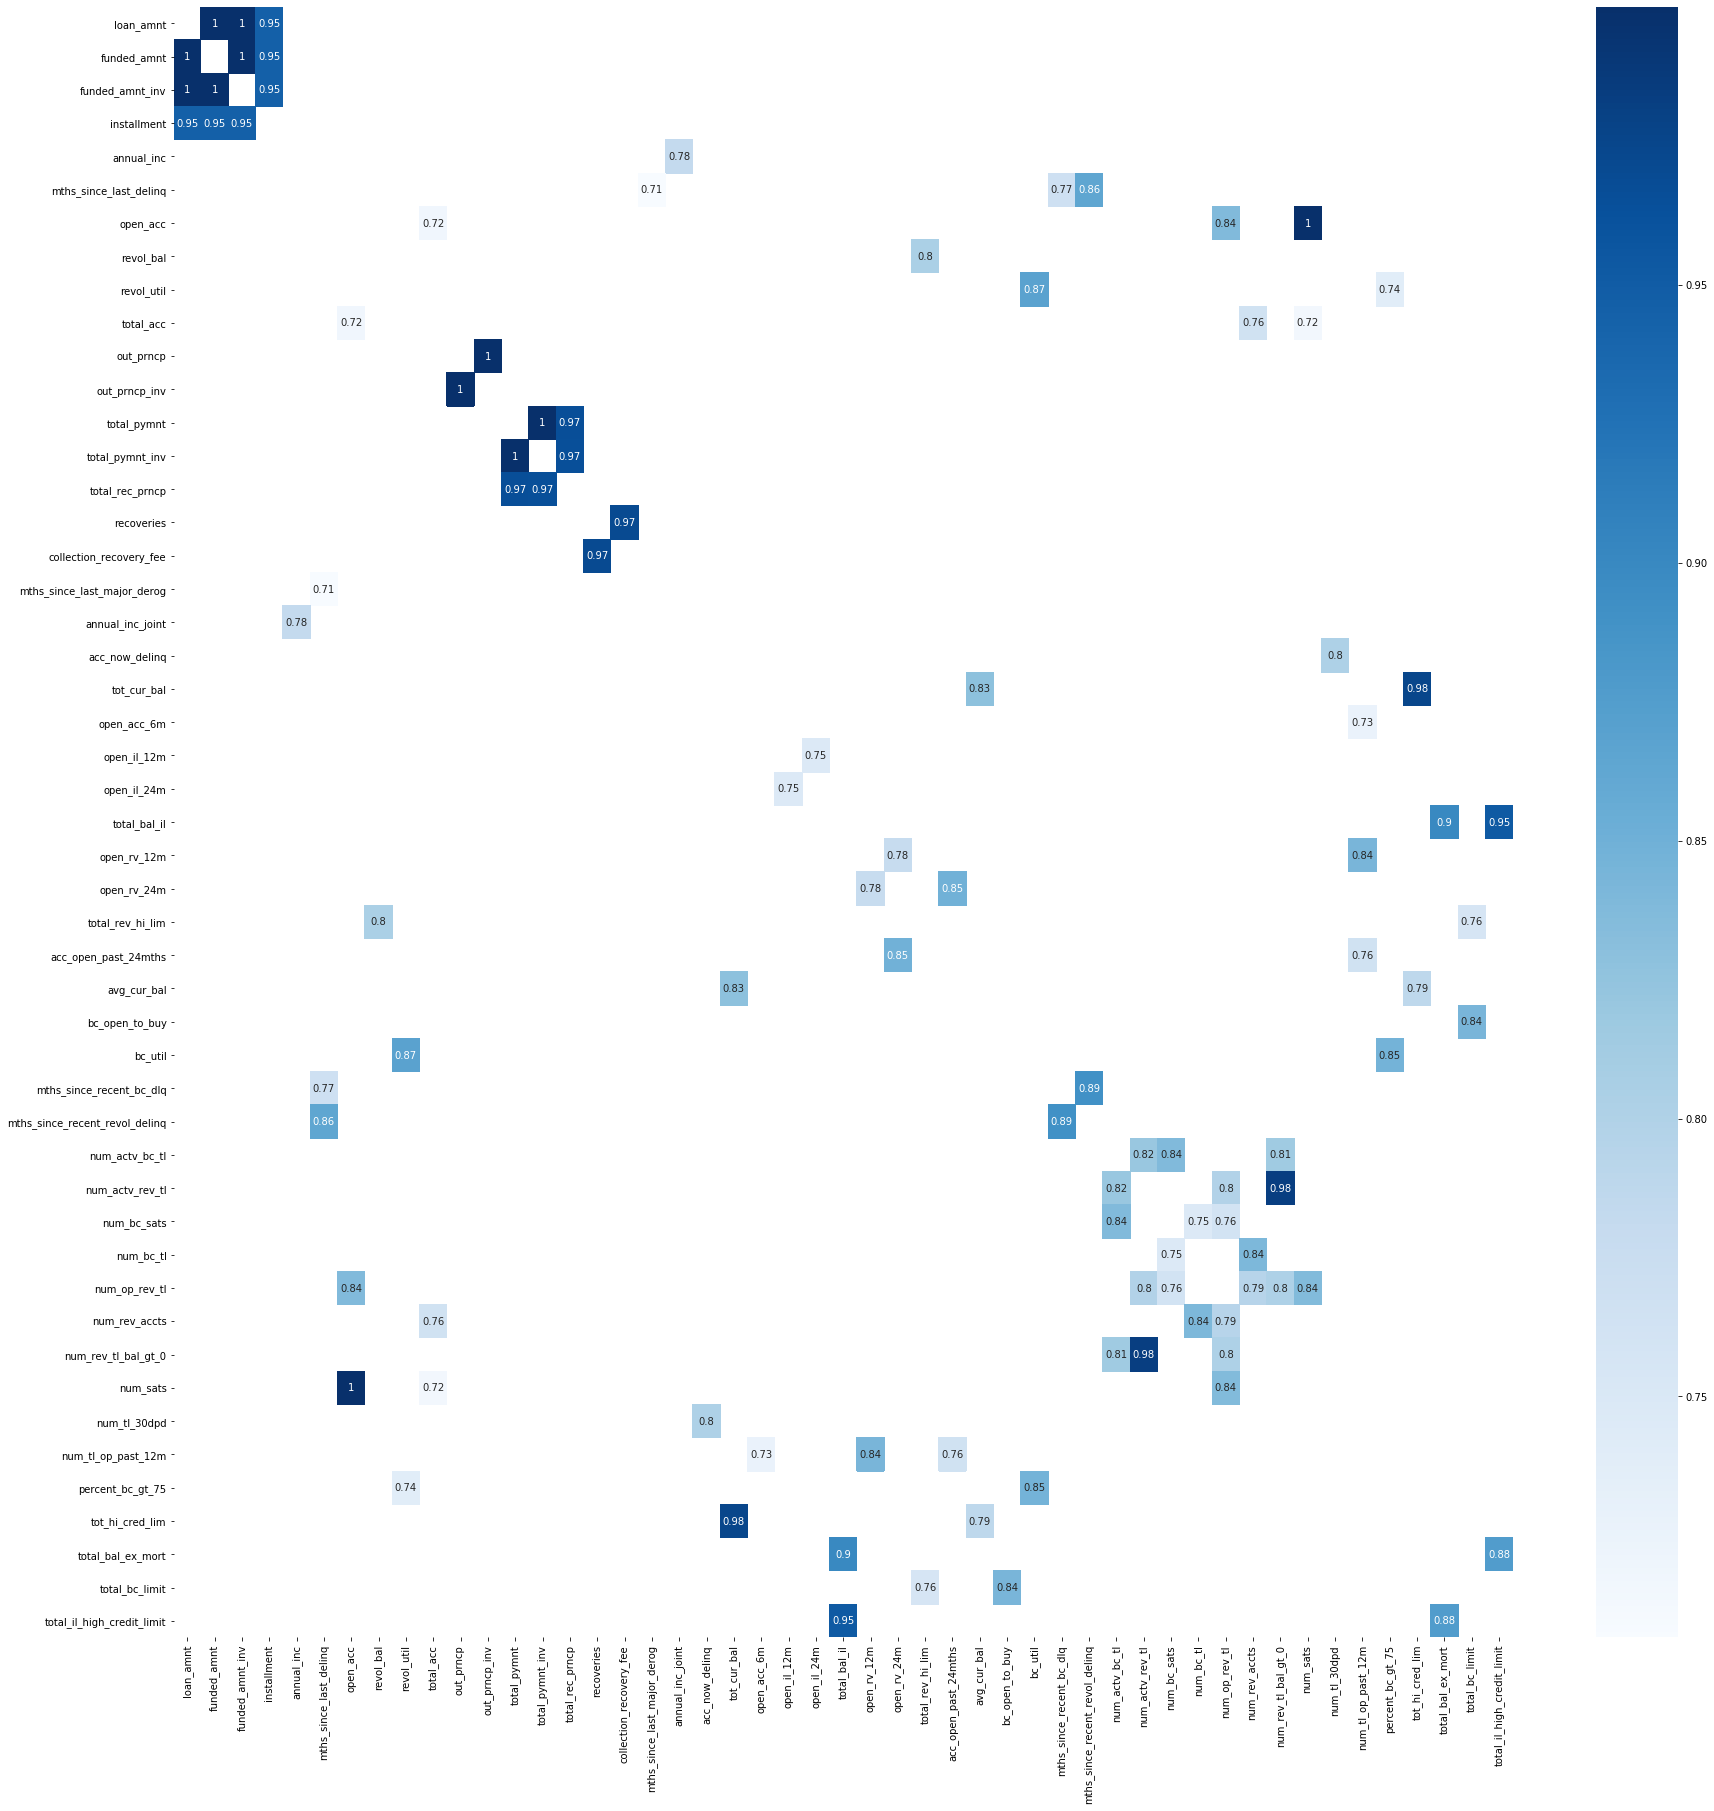

In [16]:
corr = df_number.corr(method="pearson")
big_corr=corr[abs(corr)>0.7]
big_corr.dropna(axis=0,how='all')
np.fill_diagonal(big_corr.values, np.nan)
big_corr=big_corr.dropna(axis=0,how='all')
big_corr=big_corr.dropna(axis=1,how='all')
big_corr
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(big_corr, cmap="Blues", annot = True);

#### Initial Removing anything feature that are extremely highly correlated with other features
#### First thing to take care off is that a borrower should be represented by ONE credit limit. Everything else should be expressed as fractions of the credit limit. 
#### High credit limit is better than low credit limit. high percentage of credit used is bad (low credit utilization)
#### Inquiries (bad), credit mix, payment history, credit utilization are the main factors for credit score
#### If dropping balance information (such as total_bal_il, or tot_cur_bal) is possible, then drop them first. This information will be reflected by the utilization rate such as (il_util, all_util)
#### For date related information, keep generic information such as (num_tl_op_past_12m) and drop type specific information such as (open_rv_12m). This information should be reflected by the ratio of different types of accounts (new feature from number of types of accounts)
#### drop features that say balance > 0  such as (num_rev_tl_bal_gt_0). This is because it is the same as active accounts such as (num_actv_bc_tl)

In [17]:
# total_bal_il AND total_il_high_credit_limit = 0.95            <---- drop total_bal_il 
# total_bal_ex_mort AND total_il_high_credit_limit = 0.88       <---- drop total_bal_ex_mort
# total_rev_hi_lim AND total_bc_limit = 0.76 
# bc_open_to_buy AND total_bc_limit = 0.84                      <---- drop bc_open_to_buy (covered by bc_limit)
# total_bal_il AND total_bal_ex_mort = 0.9                      <---- drop total_bal_il, total_bal_ex_mort
# total_il_high_credit_limit AND total_bal_ex_mort = 0.88       <---- drop total_bal_ex_mort
# tot_cur_bal AND tot_hi_cred_lim = 0.98                        <---- drop tot_cur_bal
# avg_cur_bal AND tot_hi_cred_lim = 0.79                        <---- drop avg_cur_bal
# bc_util AND percent_bc_gt_75 = 0.85                           <---- drop percent_bc_gt_75 (covered by bc_util)
# revol_util AND percent_bc_gt_75 = 0.74                        <---- drop percent_bc_gt_75
# open_acc_6m AND num_tl_op_past_12m = 0.73                     
# open_rv_12m AND num_tl_op_past_12m = 0.84                     <---- drop open_rv_12m
# acc_open_past_24mnths AND num_tl_op_past_12m = 0.76           
# acc_now_delinq AND num_tl_30dpd = 0.8
# open_acc AND num_sats = 1   
# total_acc AND num_sats = 0.72  
# num_op_rev_tl AND num_sats = 0.84 
# num_rev_tl_bal_gt_0 AND num_actv_bc_tl = 0.81                 <---- drop num_rev_tl_bal_gt_0                       
# num_rev_tl_bal_gt_0 AND num_actv_rev_tl =0.98                 <--- drop num_rev_tl_bal_gt_0
# num_rev_tl_bal_gt_0 AND num_op_rev_tl = 0.8                   <--- drop num_rev_tl_bal_gt_0 
# num_rev_accts AND total_acc = 0.76 
# num_rev_accts AND num_bc_tl = 0.84
# num_rev_accts AND num_op_rev_tl = 0.79

In [18]:
first_drop_df=treat_df.drop(['total_bal_il','total_bal_ex_mort','bc_open_to_buy','tot_cur_bal',\
               'avg_cur_bal','percent_bc_gt_75','open_rv_12m','num_rev_tl_bal_gt_0'],axis=1)

#### Creating the fractions for different types of accounts

In [19]:
first_drop_df.loc[:,['num_rev_accts','num_op_rev_tl','num_actv_rev_tl','num_bc_tl','num_actv_bc_tl','num_il_tl','mort_acc','total_acc','open_acc']].iloc[0:10,:]

,num_rev_accts,num_op_rev_tl,num_actv_rev_tl,num_bc_tl,num_actv_bc_tl,num_il_tl,mort_acc,total_acc,open_acc
id,,,,,,,,,
68407277,9.0,4.0,4.0,5.0,2.0,3.0,1.0,13.0,7.0
68355089,27.0,20.0,5.0,17.0,5.0,6.0,4.0,38.0,22.0
68341763,7.0,4.0,3.0,4.0,2.0,6.0,5.0,18.0,6.0
66310712,13.0,10.0,5.0,10.0,4.0,2.0,1.0,17.0,13.0
68476807,19.0,7.0,6.0,9.0,4.0,10.0,6.0,35.0,12.0
68426831,4.0,4.0,3.0,2.0,2.0,2.0,0.0,6.0,5.0
68476668,16.0,9.0,6.0,5.0,4.0,7.0,4.0,27.0,12.0
67275481,3.0,3.0,2.0,3.0,2.0,9.0,3.0,15.0,8.0
68466926,19.0,13.0,9.0,10.0,6.0,3.0,1.0,23.0,14.0


In [20]:
#### First we see that the accounts can be broken down into the following fractions (roughly):
#### num_rev_accts / total_acc = revol_frac
#### num_il_tl / total_acc = install_frac
#### mort_acc / total_acc = mort_frac

#### There are a few other unaccounted for types of accounts. We will use them as a metric for how active the borrower is: 
#### num_bc_tl / num_rev_accts = card_frac
#### num_actv_bc_tl / num_bc_tl = active_card_frac
#### num_actv_rev_tl / num_rev_accts =  active_revol_frac
#### num_op_rev_tl  /num_rev_accts =  open_revol_frac   

In [21]:
first_drop_df['revol_frac']=first_drop_df['num_rev_accts']/first_drop_df['total_acc']
first_drop_df['install_frac']=first_drop_df['num_il_tl']/first_drop_df['total_acc']
first_drop_df['mort_frac']=first_drop_df['mort_acc']/first_drop_df['total_acc']

first_drop_df['card_frac']=first_drop_df['num_bc_tl']/first_drop_df['num_rev_accts']
first_drop_df['active_card_frac']=first_drop_df['num_actv_bc_tl']/first_drop_df['num_bc_tl']
first_drop_df['active_revol_frac']=first_drop_df['num_actv_rev_tl']/first_drop_df['num_rev_accts']
first_drop_df['open_revol_frac']=first_drop_df['num_op_rev_tl']/first_drop_df['num_rev_accts']

second_drop_df=first_drop_df.drop(['num_rev_accts','num_il_tl','mort_acc','num_bc_tl','num_actv_bc_tl','num_actv_rev_tl','num_op_rev_tl'],axis=1)

#### Quick Definition of Variable Type (Continuous, Nominal, Ordinal) Again

In [22]:
df_number = second_drop_df.select_dtypes(include = 'number')
df_object = second_drop_df.select_dtypes(include = 'object')
df_category = second_drop_df.select_dtypes(include = 'category')
df_boolean = second_drop_df.select_dtypes(include = 'bool')
df_datetime = second_drop_df.select_dtypes(include = 'datetime')
df_timedelta = second_drop_df.select_dtypes(include = 'timedelta')
#######################################################
nominal_var=list(df_object.columns)
ordinal_var=list(df_number.columns)
continuous_var=list(df_number.columns)
time_var=list(df_datetime.columns)

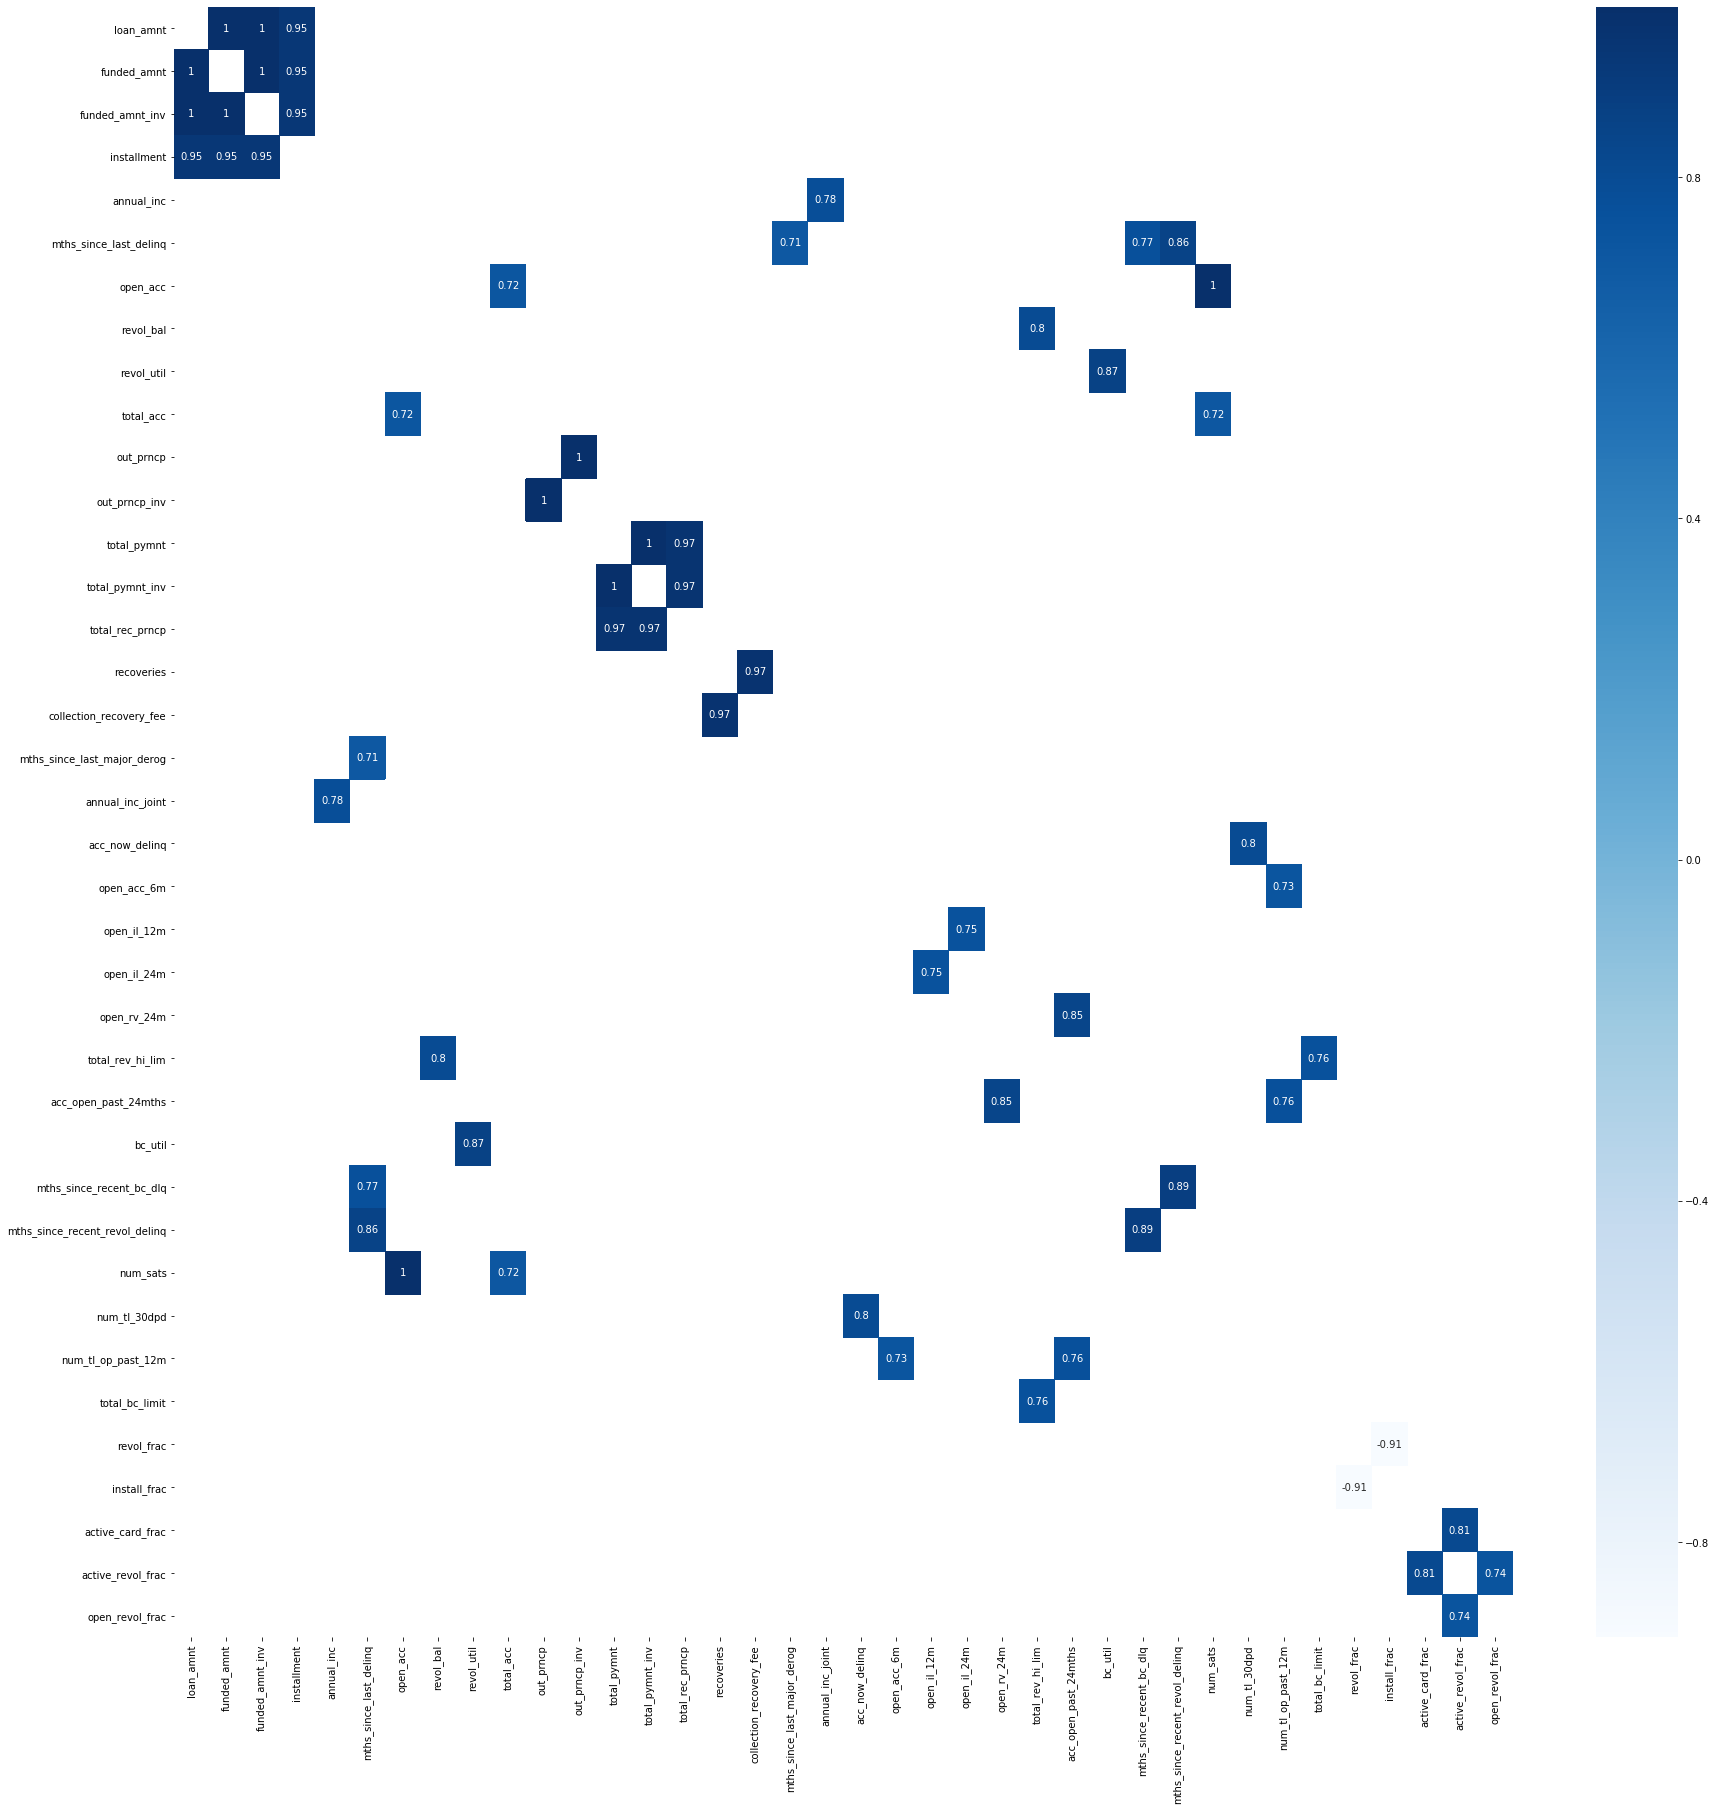

In [23]:
corr = df_number.corr(method="pearson")
big_corr=corr[abs(corr)>0.7]
big_corr.dropna(axis=0,how='all')
np.fill_diagonal(big_corr.values, np.nan)
big_corr=big_corr.dropna(axis=0,how='all')
big_corr=big_corr.dropna(axis=1,how='all')
big_corr
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(big_corr, cmap="Blues", annot = True);

#### Continuing the Removing of feature that are extremely highly correlated with other features
#### drop total_bc_limit because revolving accounts cover bank cards
#### drop num_tl_30dpd because it is covered by acc_now_delinq. Deliquency is when the account is late by 30days
#### satisfactory accounts are open accounts so remove open accounts. And create a fraction to represent fraction of accounts that are satisfactory
####  months since last delinquency together with fractions of account types should cover the months_since_recent_revol or months_since_recent_bc_dlq

In [24]:
# total_bc_limit AND total_rev_hi_lim = 0.76           <--- drop total_bc_limit because covered by total_rev_hi_lim
# num_tl_op_past_12m AND open_acc_6m = 0.73            <---- drop open_acc_6m
# num_tl_op_past_12m AND acc_open_past_24mths = 0.76   <---- drop acc_open_past_24mths
# num_tl_30dpd AND acc_now_delinq = 0.8                <---- drop num_tl_30dpd 
# num_sats AND open_acc = 1                            <---- drop open_acc
# num_sats AND total_acc = 0.72                        <---- create fraction: num_sats/total_acc = good_acc_frac
# mnths_since_recent_revol_delinq AND mnths_since_last_delinq = 0.86   <---- drop mnths_since_recent_revol_delinq
# mnths_since_recent_revol_delinq AND mnths_since_recent_bc_dlq = 0.89 <---- drop mnths_since_recent_revol_delinq
# mnths_since_recent_bc_dlq AND mnths_since_recent_revol_delinq = 0.89 <---- drop mnths_since_recent_bc_dlq
# mnths_since_recent_bc_dlq AND mnths_since_last_delinq = 0.77         <---- drop mnths_since_recent_bc_dlq


In [25]:
second_drop_df[['num_tl_op_past_12m','acc_open_past_24mths']]

,num_tl_op_past_12m,acc_open_past_24mths
id,,
68407277,3.0,4.0
68355089,2.0,4.0
68341763,0.0,6.0
66310712,1.0,2.0
68476807,4.0,10.0
68426831,0.0,0.0
68476668,2.0,6.0
67275481,0.0,4.0
68466926,2.0,7.0


In [26]:
print(pearsonr(second_drop_df.loc[~second_drop_df['num_tl_op_past_12m'].isnull(),'num_tl_op_past_12m'],second_drop_df.loc[~second_drop_df['num_tl_op_past_12m'].isnull(),'int_rate']))
print(pearsonr(second_drop_df.loc[~second_drop_df['acc_open_past_24mths'].isnull(),'acc_open_past_24mths'],second_drop_df.loc[~second_drop_df['acc_open_past_24mths'].isnull(),'int_rate']))
print(pearsonr(second_drop_df.loc[~second_drop_df['open_acc_6m'].isnull(),'open_acc_6m'],second_drop_df.loc[~second_drop_df['open_acc_6m'].isnull(),'int_rate']))

(0.18166825403475717, 0.0)
(0.171995789222534, 0.0)
(0.13606927127441076, 0.0)


In [27]:
second_drop_df['good_acc_frac'] = second_drop_df['num_sats']/second_drop_df['total_acc']
second_drop_df.drop(['num_sats','total_bc_limit','open_acc_6m','acc_open_past_24mths',\
                     'num_tl_30dpd','open_acc','mths_since_recent_revol_delinq','mths_since_recent_bc_dlq'],axis=1,inplace=True)

In [28]:
second_drop_df.to_csv('lean_df_2.csv')